<a href="https://colab.research.google.com/github/fjadidi2001/AD_Prediction/blob/main/Alzheimer%E2%80%99s_Dementia_Speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pydub

In [2]:
import os
import tarfile
import glob
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import wavfile
from pydub import AudioSegment
from pydub.silence import split_on_silence
import soundfile as sf
from sklearn.preprocessing import StandardScaler
import uuid
from pathlib import Path

In [3]:
# Step 1: Load Dataset from Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define paths to the .tgz files
data_path = '/content/drive/MyDrive/Voice/ADRESS021/'
train_prog_tgz = os.path.join(data_path, 'ADRESS021-progression-train.tgz')
test_prog_tgz = os.path.join(data_path, 'ADRESS021-progression-test.tgz')
train_diag_tgz = os.path.join(data_path, 'ADRESS021-diagnosis-train.tgz')

# Extract .tgz files
extracted_path = '/content/adress021_data/'
os.makedirs(extracted_path, exist_ok=True)

Mounted at /content/drive


In [4]:
import tarfile
import glob
import os

# Define file paths
train_prog_tgz = '/content/drive/MyDrive/Voice/ADReSSo21-progression-train.tgz'
test_prog_tgz = '/content/drive/MyDrive/Voice/ADReSSo21-progression-test.tgz'
train_diag_tgz = '/content/drive/MyDrive/Voice/ADReSSo21-diagnosis-train.tgz'
extracted_path = '/content/extracted_audio'  # Directory to extract files to

# Ensure extracted_path exists
os.makedirs(extracted_path, exist_ok=True)

# Function to extract .tgz files
def extract_tgz(tgz_path, extract_to):
    try:
        with tarfile.open(tgz_path, 'r:gz') as tar:
            tar.extractall(path=extract_to)
        print(f"Successfully extracted {tgz_path} to {extract_to}")
    except FileNotFoundError:
        print(f"Error: File {tgz_path} not found.")
    except Exception as e:
        print(f"Error extracting {tgz_path}: {str(e)}")

# Extract each .tgz file
for tgz in [train_prog_tgz, test_prog_tgz, train_diag_tgz]:
    if os.path.exists(tgz):
        extract_tgz(tgz, extracted_path)
    else:
        print(f"Skipping {tgz}: File does not exist.")

# Find all WAV files
audio_files = glob.glob(os.path.join(extracted_path, '**/*.wav'), recursive=True)
print(f"Found {len(audio_files)} audio files.")

Successfully extracted /content/drive/MyDrive/Voice/ADReSSo21-progression-train.tgz to /content/extracted_audio
Successfully extracted /content/drive/MyDrive/Voice/ADReSSo21-progression-test.tgz to /content/extracted_audio
Successfully extracted /content/drive/MyDrive/Voice/ADReSSo21-diagnosis-train.tgz to /content/extracted_audio
Found 271 audio files.


In [5]:
# Load metadata (assuming there's a CSV or text file with labels)
# Modify this based on actual metadata structure
metadata_path = glob.glob(os.path.join(extracted_path, '**/*.csv'), recursive=True)
if metadata_path:
    metadata = pd.read_csv(metadata_path[0])
    print("Metadata loaded:")
    print(metadata.head())
else:
    metadata = pd.DataFrame({'file': audio_files, 'label': 'unknown'})
    print("No metadata CSV found. Using file paths only.")

Metadata loaded:
   Unnamed: 0 adressfname  mmse  dx
0          23    adrso024    20  ad
1          24    adrso025    11  ad
2          25    adrso027    18  ad
3          26    adrso028    18  ad
4          28    adrso031    26  ad


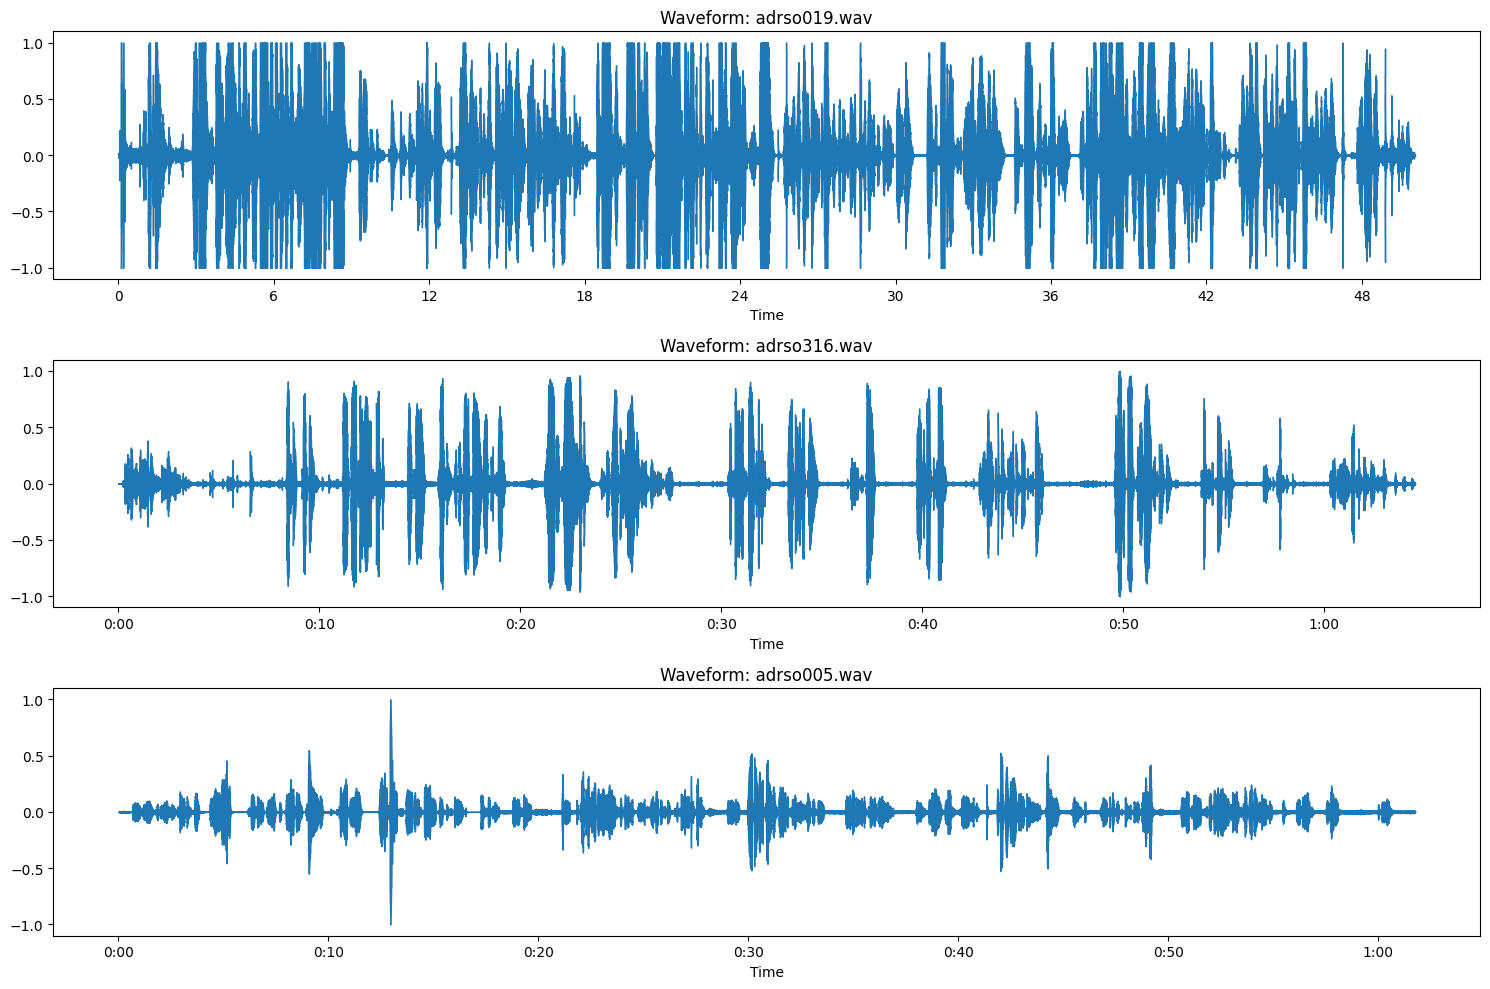


Sample Metadata:
   Unnamed: 0 adressfname  mmse  dx
0          23    adrso024    20  ad
1          24    adrso025    11  ad
2          25    adrso027    18  ad
3          26    adrso028    18  ad
4          28    adrso031    26  ad


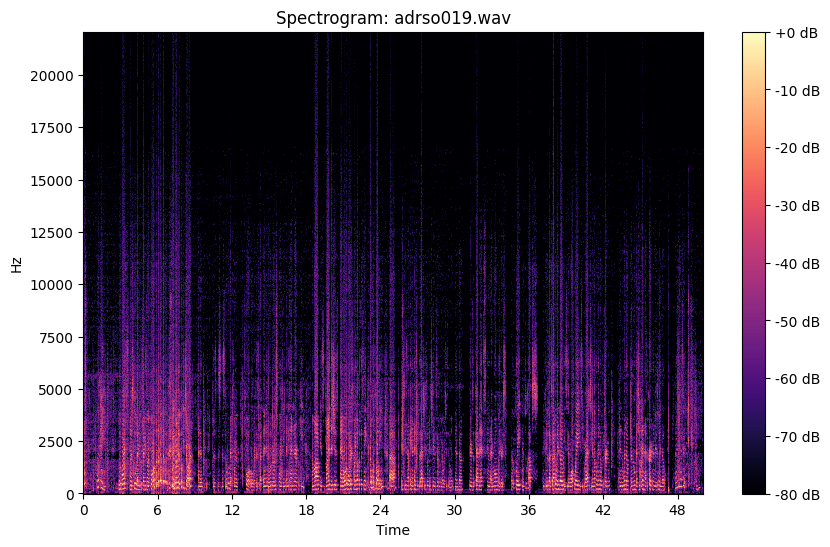

No label column found in metadata.


In [6]:
# Step 2: Visualize and Explore Dataset
# Select a few sample audio files
sample_files = audio_files[:3]

# Visualize waveforms
plt.figure(figsize=(15, 10))
for i, audio_file in enumerate(sample_files):
    y, sr = librosa.load(audio_file, sr=None)
    plt.subplot(len(sample_files), 1, i+1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform: {os.path.basename(audio_file)}")
plt.tight_layout()
plt.savefig('/content/waveforms.png')
plt.show()

# Show sample metadata
print("\nSample Metadata:")
print(metadata.head())

# Plot spectrogram for one sample
y, sr = librosa.load(sample_files[0], sr=None)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
plt.figure(figsize=(10, 6))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title(f"Spectrogram: {os.path.basename(sample_files[0])}")
plt.savefig('/content/spectrogram.png')
plt.show()

# Show label distribution (assuming metadata has a 'label' column)
if 'label' in metadata.columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=metadata, x='label')
    plt.title('Label Distribution')
    plt.savefig('/content/label_distribution.png')
    plt.show()
else:
    print("No label column found in metadata.")

In [11]:
import os
import glob
import librosa
import numpy as np
import pandas as pd
import soundfile as sf
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Define paths
extracted_path = '/content/extracted_audio/'  # Corrected from /content/adress021_data/
output_dir = '/content/processed_features/'
os.makedirs(output_dir, exist_ok=True)

# Load metadata (assuming CSV from Step 1/2)
metadata_path = glob.glob(os.path.join(extracted_path, '**/*.csv'), recursive=True)
if metadata_path:
    metadata = pd.read_csv(metadata_path[0])
    metadata['dx'] = metadata['dx'].astype(str)  # Ensure dx is string
else:
    raise FileNotFoundError("Metadata CSV not found in extracted path.")

# Find WAV files
audio_files = glob.glob(os.path.join(extracted_path, '**/*.wav'), recursive=True)
print(f"Found {len(audio_files)} audio files.")

# Match audio files with metadata
# Assume adressfname (e.g., adrso024) corresponds to file name (e.g., adrso024.wav)
audio_metadata = []
for audio_file in audio_files:
    fname = os.path.basename(audio_file).replace('.wav', '')
    matching_row = metadata[metadata['adressfname'] == fname]
    if not matching_row.empty:
        audio_metadata.append({
            'file': audio_file,
            'label': matching_row['dx'].iloc[0],
            'mmse': matching_row['mmse'].iloc[0]
        })
audio_metadata = pd.DataFrame(audio_metadata)
print(f"Matched {len(audio_metadata)} audio files with metadata.")

# Limit to a subset for testing
subset_size = 10  # Adjust as needed
audio_metadata = audio_metadata[:subset_size]
print(f"Processing {len(audio_metadata)} files for testing.")

# Preprocessing function for a single audio file
def process_audio(audio_file, sr=16000, skip_noise_removal=True):
    # Load audio
    y, orig_sr = librosa.load(audio_file, sr=sr, mono=True)

    # Skip noise removal to save time
    y_processed = y if skip_noise_removal else librosa.decompose.nn_filter(y, aggregate=np.median, metric='cosine')

    # Trim silence
    y_trimmed, _ = librosa.effects.trim(y_processed, top_db=20)

    # Feature Extraction
    # Acoustic: MFCCs
    mfccs = librosa.feature.mfcc(y=y_trimmed, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)

    # Prosodic: Pitch, Energy
    pitches, magnitudes = librosa.piptrack(y=y_trimmed, sr=sr)
    pitch_mean = np.mean(pitches[pitches > 0]) if np.any(pitches > 0) else 0
    energy = np.mean(librosa.feature.rms(y=y_trimmed))

    # Linguistic: Placeholder (requires ASR)
    linguistic_features = np.array([0, 0])

    # Combine features
    features = np.concatenate([mfccs_mean, [pitch_mean, energy], linguistic_features])

    return y_trimmed, features

# Process all files
processed_features = []
processed_audio_paths = []
labels = []

for idx, row in tqdm(audio_metadata.iterrows(), total=len(audio_metadata), desc="Processing audio files"):
    try:
        # Process audio
        y_trimmed, features = process_audio(row['file'])

        # Save processed audio
        output_path = os.path.join(output_dir, os.path.basename(row['file']))
        sf.write(output_path, y_trimmed, 16000)

        processed_features.append(features)
        processed_audio_paths.append(output_path)
        labels.append(row['label'])

        print(f"Processed: {os.path.basename(row['file'])} (Label: {row['label']})")
    except Exception as e:
        print(f"Error processing {row['file']}: {e}")

# Convert to numpy arrays
processed_features = np.array(processed_features)
labels = np.array(labels)
print(f"Extracted features shape: {processed_features.shape}")
print(f"Labels shape: {labels.shape}")

# Feature Normalization
if processed_features.size > 0:
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(processed_features)

    # Data Augmentation (simple noise addition)
    augmented_features = normalized_features + np.random.normal(0, 0.01, normalized_features.shape)

    # Export Features
    np.save(os.path.join(output_dir, 'normalized_features.npy'), normalized_features)
    np.save(os.path.join(output_dir, 'augmented_features.npy'), augmented_features)
    np.save(os.path.join(output_dir, 'labels.npy'), labels)

    # Save processed audio file list and metadata
    audio_metadata.to_csv(os.path.join(output_dir, 'processed_metadata.csv'), index=False)
    with open(os.path.join(output_dir, 'processed_audio_files.txt'), 'w') as f:
        for path in processed_audio_paths:
            f.write(f"{path}\n")

    print(f"Features and metadata saved to {output_dir}")
else:
    print("No features extracted. Check audio files and metadata matching.")

Found 271 audio files.
Matched 166 audio files with metadata.
Processing 10 files for testing.


Processing audio files:  10%|█         | 1/10 [00:01<00:11,  1.32s/it]

Processed: adrso019.wav (Label: cn)


Processing audio files:  20%|██        | 2/10 [00:01<00:05,  1.43it/s]

Processed: adrso316.wav (Label: cn)


Processing audio files:  30%|███       | 3/10 [00:01<00:03,  2.05it/s]

Processed: adrso005.wav (Label: cn)


Processing audio files:  40%|████      | 4/10 [00:02<00:02,  2.35it/s]

Processed: adrso183.wav (Label: cn)


Processing audio files:  50%|█████     | 5/10 [00:02<00:01,  2.65it/s]

Processed: adrso158.wav (Label: cn)


Processing audio files:  60%|██████    | 6/10 [00:02<00:01,  2.86it/s]

Processed: adrso002.wav (Label: cn)


Processing audio files:  70%|███████   | 7/10 [00:03<00:01,  2.94it/s]

Processed: adrso015.wav (Label: cn)


Processing audio files:  90%|█████████ | 9/10 [00:03<00:00,  3.47it/s]

Processed: adrso180.wav (Label: cn)
Processed: adrso186.wav (Label: cn)


Processing audio files: 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

Processed: adrso265.wav (Label: cn)
Extracted features shape: (10, 17)
Labels shape: (10,)
Features and metadata saved to /content/processed_features/


In [12]:
audio_files = glob.glob(os.path.join('/content/extracted_audio/', '**/*.wav'), recursive=True)
metadata = pd.read_csv(glob.glob(os.path.join('/content/extracted_audio/', '**/*.csv'), recursive=True)[0])
audio_fnames = [os.path.basename(f).replace('.wav', '') for f in audio_files]
unmatched = [f for f in audio_fnames if f not in metadata['adressfname'].values]
print(f"Unmatched files ({len(unmatched)}):", unmatched[:10])  # Print first 10

Unmatched files (105): ['adrspt1', 'adrspt22', 'adrspt28', 'adrspt19', 'adrspt30', 'adrspt12', 'adrspt16', 'adrspt2', 'adrspt4', 'adrspt13']


In [13]:
import pandas as pd
metadata = pd.read_csv(glob.glob(os.path.join('/content/extracted_audio/', '**/*.csv'), recursive=True)[0])
print(metadata['dx'].value_counts())

dx
ad    87
cn    79
Name: count, dtype: int64


In [14]:
import pandas as pd
processed_metadata = pd.read_csv('/content/processed_features/processed_metadata.csv')
print(processed_metadata['label'].value_counts())

label
cn    10
Name: count, dtype: int64


In [16]:
import numpy as np
import pandas as pd
norm_features = np.load('/content/processed_features/normalized_features.npy')
labels = np.load('/content/processed_features/labels.npy')
metadata = pd.read_csv('/content/processed_features/processed_metadata.csv')
print(f"Features shape: {norm_features.shape}")
print(f"Labels: {labels}")
print(metadata[['file', 'label']])

Features shape: (10, 17)
Labels: ['cn' 'cn' 'cn' 'cn' 'cn' 'cn' 'cn' 'cn' 'cn' 'cn']
                                                file label
0  /content/extracted_audio/ADReSSo21/diagnosis/t...    cn
1  /content/extracted_audio/ADReSSo21/diagnosis/t...    cn
2  /content/extracted_audio/ADReSSo21/diagnosis/t...    cn
3  /content/extracted_audio/ADReSSo21/diagnosis/t...    cn
4  /content/extracted_audio/ADReSSo21/diagnosis/t...    cn
5  /content/extracted_audio/ADReSSo21/diagnosis/t...    cn
6  /content/extracted_audio/ADReSSo21/diagnosis/t...    cn
7  /content/extracted_audio/ADReSSo21/diagnosis/t...    cn
8  /content/extracted_audio/ADReSSo21/diagnosis/t...    cn
9  /content/extracted_audio/ADReSSo21/diagnosis/t...    cn


In [17]:
from IPython.display import Audio
Audio('/content/processed_features/adrso019.wav')